In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rvlcdip/labels_final.csv
/kaggle/input/rvlcdip/data_final/imagesz/z/n/n/znn61f00/2051520494_2051520495.tif
/kaggle/input/rvlcdip/data_final/imagesz/z/n/n/znn21a00/0071017351.tif
/kaggle/input/rvlcdip/data_final/imagesz/z/n/n/znn74e00/1000244283.tif
/kaggle/input/rvlcdip/data_final/imagesz/z/n/n/znn35c00/2083965895.tif
/kaggle/input/rvlcdip/data_final/imagesz/z/n/n/znn09d00/50448234-8237.tif
/kaggle/input/rvlcdip/data_final/imagesz/z/n/n/znn53c00/95602574.tif
/kaggle/input/rvlcdip/data_final/imagesz/z/n/r/znr26e00/2048401102.tif
/kaggle/input/rvlcdip/data_final/imagesz/z/n/r/znr72a00/528059034+-9039.tif
/kaggle/input/rvlcdip/data_final/imagesz/z/n/r/znr10f00/0000092152.tif
/kaggle/input/rvlcdip/data_final/imagesz/z/n/r/znr78d00/502598229.tif
/kaggle/input/rvlcdip/data_final/imagesz/z/n/b/znb53a00/2065114155.tif
/kaggle/input/rvlcdip/data_final/imagesz/z/n/b/znb31f00/0001452447.tif
/kaggle/input/rvlcdip/data_final/imagesz/z/n/b/znb59c00/PUBLICATIONS009168-9.tif
/kaggle/inpu

In [2]:
import os
import numpy as np
import pandas as pd
import random as rn

import tensorflow as tf
import keras

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.models import Sequential

from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.layers import Input, Dense,Conv2D,MaxPool2D,Activation,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers

In [3]:
dir_path = '/kaggle/input/rvlcdip/'
os.listdir(dir_path)

['labels_final.csv', 'data_final']

In [4]:
train_df = pd.read_csv('/kaggle/input/rvlcdip/labels_final.csv')

In [5]:
train_df.head()

path  label
0  imagesv/v/o/h/voh71d00/509132755+-2755.tif      3
1        imagesl/l/x/t/lxt19d00/502213303.tif      3
2       imagesx/x/e/d/xed05a00/2075325674.tif      2
3  imageso/o/j/b/ojb60d00/517511301+-1301.tif      3
4       imagesq/q/z/k/qzk17e00/2031320195.tif      7

In [6]:
train_df['path'].head()

0    imagesv/v/o/h/voh71d00/509132755+-2755.tif
1          imagesl/l/x/t/lxt19d00/502213303.tif
2         imagesx/x/e/d/xed05a00/2075325674.tif
3    imageso/o/j/b/ojb60d00/517511301+-1301.tif
4         imagesq/q/z/k/qzk17e00/2031320195.tif
Name: path, dtype: object

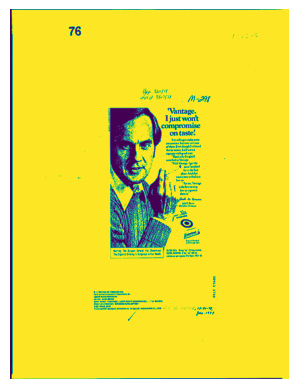

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and display a .tif image
image_path = '/kaggle/input/rvlcdip/data_final/imagesv/v/o/h/voh71d00/509132755+-2755.tif'
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [8]:
train_df['label'].value_counts()

label
0     3016
13    3007
14    3006
12    3006
3     3005
8     3003
9     3002
10    3002
7     3000
5     2999
15    2996
1     2994
4     2994
2     2993
11    2992
6     2985
Name: count, dtype: int64

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                            rescale = 1./255,
                                                            rotation_range = 10,
                                                            width_shift_range = 0.1,
                                                            height_shift_range = 0.1,
                                                            shear_range = 0.1,
                                                            zoom_range = 0.1,
                                                            horizontal_flip = True,
                                                            validation_split = 0.2)

In [10]:
train_generator = datagen.flow_from_dataframe(dataframe= train_df,
                                              directory='/kaggle/input/rvlcdip/data_final/',
                                              x_col = 'path',
                                              y_col = 'label',
                                              subset = 'training',
                                              batch_size=100,
                                              seed=42,
                                              shuffle=True,
                                              class_mode="raw",
                                              target_size=(224,224))

Found 38400 validated image filenames.


In [11]:
valid_generator = datagen.flow_from_dataframe(dataframe= train_df,
                                              directory='/kaggle/input/rvlcdip/data_final/',
                                              x_col = 'path',
                                              y_col = 'label',
                                              subset = 'validation',
                                              batch_size=100,
                                              seed=42,
                                              shuffle=True,
                                              class_mode="raw",
                                              target_size=(224,224))

Found 9600 validated image filenames.


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation = 'relu', input_shape=(224, 224,3)),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128, (3,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(16, activation = 'softmax'), # 16 classes probability of all 16 classes.
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,256 (42.64 MB)

 Trainable params: 11,178,256 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping, TensorBoard
import os
import datetime


In [15]:
checkpoint_path = "kaggle/working/model_checkpoints/weights.{epoch:02d}-{val_loss:2f}.keras"
log_dir = "/kaggle/working/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


# Epoch 1 - Weights.keras
# epoch 2 - Weights.keras

# Naming format - "weights.{epoch:02d}-{val_loss:2f}.keras"

model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min', 
                                   verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
board = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [model_checkpoint, reduce_lr, early_stop, board]


# e1 - 0.7 ( check point )
# e2 - 0.71
# e3 - 0.72
# e4 - 0.75
# e5 - 0.8
# stop the training- restore my check point.

# reduce my lr
# e4 - 0.65
# when ever there is improvement, i want the model to be saved.

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,256 (42.64 MB)

 Trainable params: 11,178,256 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer = 'adam',
             loss= 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [18]:
history = model.fit(
                    train_generator,
                    validation_data=valid_generator,
                    epochs=50,
                    callbacks=callbacks
                    )

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731040612.108338      67 service.cc:145] XLA service 0x7be90000b770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731040612.108392      67 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731040612.108396      67 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731040624.808556      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2148 - loss: 2.5103

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 2.03251, saving model to kaggle/working/model_checkpoints/weights.01-2.032510.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 1049s 3s/step - accuracy: 0.2150 - loss: 2.5096 - val_accuracy: 0.3629 - val_loss: 2.0325 - learning_rate: 0.0010
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4183 - loss: 1.8616
Epoch 2: val_loss improved from 2.03251 to 1.62754, saving model to kaggle/working/model_checkpoints/weights.02-1.627536.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 705s 2s/step - accuracy: 0.4184 - loss: 1.8614 - val_accuracy: 0.5017 - val_loss: 1.6275 - learning_rate: 0.0010
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5020 - loss: 1.5999
Epoch 3: val_loss improved from 1.62754 to 1.47840, saving model to kaggle/working/model_checkpoints/weights.03-1.478402.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 693s 2s/step - accuracy: 0.5020 - loss: 1.5998 - val_accuracy: 0.5496 - val_loss: 1.4784 - learning_rate: 0.0010
Epoch 4/50
384/384 ━━━━━━